# **1. Install and Import Dependencies**

In [18]:
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install scikit-learn
%pip install matplotlib
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     -------------------------------------- 160.4/160.4 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.5 MB 33.4 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/7.5 MB 27.1 MB/s eta 0:00:01
   ---------------------- ----------------- 4.3/7.5 MB 30.4 MB/s eta 0:00:01
   --------------------------------- ------ 6.4/7.5 MB 33.8 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 34.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/477.9 kB ? eta -:--:-

In [1]:
# Nick

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
    # Do some computations with CUDA tensors
    a = torch.randn(1000, 1000, device='cuda')
    b = torch.randn(1000, 1000, device='cuda')
    c = torch.matmul(a, b)
    # Clear the CUDA memory
    torch.cuda.empty_cache()

    # Check the current memory usage
    print(f"Current CUDA memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
    
print(device)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080
Current CUDA memory usage: 20.00 MB
cuda


# **2. Load dataset**

In [2]:
# Nick

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd
import numpy as np
import os

# put csv file in pandas dataframe
df = pd.read_csv('../../IMDB Dataset.csv')
df['sentiment'] = np.where(df['sentiment'] == "positive", 1, df['sentiment'])
df['sentiment'] = np.where(df['sentiment'] == "negative", 0, df['sentiment'])

df_train = df[:int(len(df)*0.8)]
df_test  = df[int(len(df)*0.8):]

# put dataframes into Dataset format
raw_train_dataset = Dataset.from_pandas(df_train)
raw_test_dataset = Dataset.from_pandas(df_test)

# initialize tokenizer to the chosen model
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
  return tokenizer(example['review'], truncation=True)

# tokenize train and test datasets using tokenize_function
tokenized_train_dataset = raw_train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset =  raw_test_dataset.map(tokenize_function, batched=True)

c:\xampp\htdocs\MovieReviewAI\MovieReviewSentimentNLP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 10000/10000 [00:02<00:00, 4869.28 examples/s]


In [3]:
# Nick

# rename classification column to "labels" for acceptable tensor format
tokenized_train_dataset = tokenized_train_dataset.rename_column("sentiment", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("sentiment", "labels")
print(tokenized_train_dataset)
print(tokenized_test_dataset)

Dataset({
    features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})
Dataset({
    features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


In [4]:
# Nick

# remove "review" column to maintain acceptable tensor format
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["review"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["review"])
print(tokenized_train_dataset)
print(tokenized_test_dataset)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


In [5]:
# Nick

# change datatype to pytorch tensor for train and test datasets
tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")
print(tokenized_train_dataset)

# initialize data collator
data_collator = DataCollatorWithPadding(tokenizer)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40000
})


In [6]:
# Nick

from torch.utils.data import DataLoader
# load data into DataLoaders for training/validation
train_dataloader = DataLoader(
    tokenized_train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator, 
)

test_dataloader = DataLoader(
    tokenized_test_dataset, batch_size = 8, collate_fn=data_collator
)

In [7]:
# Matt

# print example of train_dataloader content
for batch in train_dataloader:
  break
print({k: v.shape for k,v in batch.items()})

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([8]), 'input_ids': torch.Size([8, 512]), 'token_type_ids': torch.Size([8, 512]), 'attention_mask': torch.Size([8, 512])}


# **2. Instantiate Model**

In [8]:
# Matt

from transformers import AutoModelForSequenceClassification
checkpoint = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
# Matt

batch = batch.to(device)
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [10]:
# Matt

# initialize optimizer
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

c:\xampp\htdocs\MovieReviewAI\MovieReviewSentimentNLP\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
# Matt

# initialize learning rate scheduler
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [12]:
# Alex

# train and evaluate model over epochs
from tqdm.auto import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import evaluate

progress_bar = tqdm(range(num_training_steps))

epoch_train_loss = []
epoch_val_loss = []

for epoch in range(num_epochs):
    # train
    train_loss = []
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    print("Epoch {} Avg train loss: {}".format(epoch, np.mean(train_loss)))
    epoch_train_loss.append(np.mean(train_loss))
    
    # eval
    val_loss = []
    model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        
        loss = outputs.loss
        val_loss.append(loss.item())
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    
    print("Epoch {} Avg val loss: {}".format(epoch, np.mean(val_loss)))
    epoch_val_loss.append(np.mean(val_loss))

 20%|██        | 5000/25000 [19:50<1:22:15,  4.05it/s]

Epoch 0 Avg train loss: 0.28596187075162305
Epoch 0 Avg val loss: 0.2145010845258832


 40%|████      | 10000/25000 [41:35<1:12:49,  3.43it/s] 

Epoch 1 Avg train loss: 0.16070840444390197
Epoch 1 Avg val loss: 0.20623671978432684


 60%|██████    | 15000/25000 [1:08:55<49:55,  3.34it/s]  

Epoch 2 Avg train loss: 0.08255431229209644
Epoch 2 Avg val loss: 0.2057200950998813


 80%|████████  | 20000/25000 [1:34:58<23:12,  3.59it/s]   

Epoch 3 Avg train loss: 0.03811715572641697
Epoch 3 Avg val loss: 0.2665210062405793


100%|██████████| 25000/25000 [2:01:00<00:00,  3.08it/s]   

Epoch 4 Avg train loss: 0.016931035703327508
Epoch 4 Avg val loss: 0.30470738430998756


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


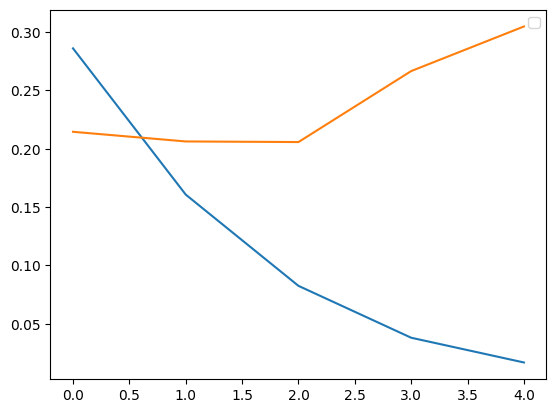

In [19]:
# Alex
# visualize loss ratios using line chart
import matplotlib.pyplot as plt


plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.legend()
plt.show()


# **3. Encode and Calculate Sentiment**

In [15]:
# Alex

# test the model with an example
tokens = tokenizer.encode("I hated this movie, it was worse than the second film.", return_tensors='pt')
result = model(tokens.to(device))
result.logits
int(torch.argmax(result.logits))

0

# **5. Evaluation**

In [16]:
# Matt and Alex

# do final evaluation on fine-tuned model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import evaluate

# initialize evaluation functions
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

model.eval()

# create arrays for confusion matrix data
y_true = []
y_pred = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

    # add batch to confusion matrix arrays
    y_true.extend(batch["labels"].tolist())
    y_pred.extend(predictions.tolist())

print("Accuracy:", accuracy_metric.compute())
print("Precision:", precision_metric.compute())
print("Recall:", recall_metric.compute())

Accuracy: {'accuracy': 0.9297}
Precision: {'precision': 0.9278330019880716}
Recall: {'recall': 0.9320950669063311}


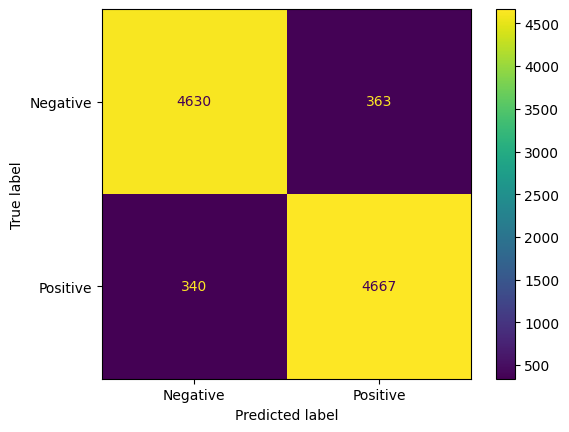

In [20]:
# Alex

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
display.plot()

In [21]:
# Alex

import joblib

# save the model to disk
filename = './new_finetuned_model.sav'

#model, tokenizer = joblib.load('./finetuned_model.sav')
model.to("cpu")

joblib.dump(value=[model, tokenizer], filename=filename, compress=0)



['./new_finetuned_model.sav']